In [25]:
!pip install langgraph -q

# LangGraph Stage 1

### Simple Graph

In [26]:
from typing import TypedDict

In [27]:
class AgentState(TypedDict):
  name : str
  age : int
  message : str

In [28]:
def hello_name(state : AgentState)-> AgentState:
  state['message'] = f"Hello {state['name']}!"
  return state

def hello_age(state : AgentState)-> AgentState:
  state['message'] = f"{state['message']} Your age is {state['age']}"
  return state

In [29]:
from langgraph.graph import StateGraph, START, END

In [30]:
workflow = StateGraph(AgentState)

workflow.add_node("hello_name", hello_name)
workflow.add_node("hello_age", hello_age)

workflow.add_edge(START, "hello_name")
workflow.add_edge("hello_name", "hello_age")
workflow.add_edge("hello_age", END)

hello_app = workflow.compile()

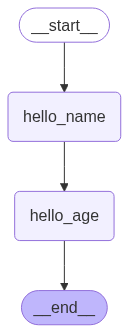

In [31]:
from IPython.display import Image, display
display(Image(hello_app.get_graph().draw_mermaid_png()))

In [32]:
result = hello_app.invoke({"name": "Nadeeshani", "age": 25})
print(result['message'])

Hello Nadeeshani! Your age is 25


### Conditional Graph

In [33]:
class AgentState(TypedDict):
  num1 : int
  num2 : int
  operation : str
  result : int

In [34]:
def addition(state : AgentState) -> AgentState:
  state['result'] = state["num1"] + state["num2"]
  return state

def subtraction(state : AgentState) -> AgentState:
  state['result'] = state["num1"] - state["num2"]
  return state

def multiplication(state : AgentState) -> AgentState:
  state['result'] = state["num1"] * state["num2"]
  return state

def division(state : AgentState) -> AgentState:
  state['result'] = state["num1"] / state["num2"]
  return state

def decision_node(state: AgentState) -> AgentState:
  if state["operation"] == "+":
    return "addition_operation"
  elif state["operation"] == "-":
    return "subtraction_operation"
  elif state["operation"] == "*":
    return "multiplication_operation"
  elif state["operation"] == "/":
    return "division_operation"

In [35]:
workflow = StateGraph(AgentState)

workflow.add_node("addition", addition)
workflow.add_node("subtraction", subtraction)
workflow.add_node("multiplication", multiplication)
workflow.add_node("division", division)
workflow.add_node("router", lambda state:state)

workflow.add_edge(START, "router")
workflow.add_conditional_edges(
    "router", decision_node,
    {
        "addition_operation": "addition",
        "subtraction_operation": "subtraction",
        "multiplication_operation": "multiplication",
        "division_operation": "division"
    }
)

workflow.add_edge("addition", END)
workflow.add_edge("subtraction", END)
workflow.add_edge("multiplication", END)
workflow.add_edge("division", END)

app = workflow.compile()

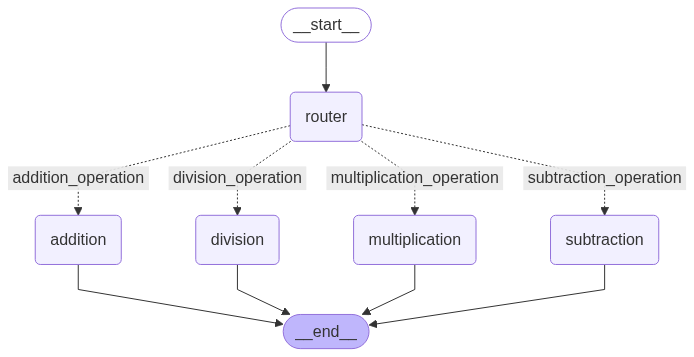

In [36]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
result = app.invoke({"num1": 10, "num2": 25, "operation": "-"})
print(result['result'])

-15


# LangGraph Stage 2

## Chatbot

In [70]:
!pip install langchain==0.3.24 -q
!pip install google-ai-generativelanguage==0.6.15
!pip install langchain -q

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 111, in resolve
    for candidate in sorted(
                     ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 112, in <lambda>
    result.mapping.values(), key=lambda c: c.name != c.project_name
                                

In [71]:
from typing import TypedDict, List, Union
from langchain.schema import HumanMessage, AIMessage

In [72]:
class AgentState(TypedDict):
  messages: List[Union[HumanMessage, AIMessage]]

In [73]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [74]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0
    )

In [75]:
def chatbot(state : AgentState)-> AgentState:
  response = llm.invoke(state['messages'])
  state['messages'].append(AIMessage(content=response.content))
  print(f"\nAI: {response.content}")
  return state

In [76]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

chatbot_app = workflow.compile()

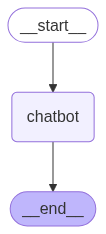

In [77]:
from IPython.display import Image, display
display(Image(chatbot_app.get_graph().draw_mermaid_png()))

In [78]:
history = []

user_input = input("User: ")
while user_input != "exit":
  history.append(HumanMessage(content=user_input))
  result = chatbot_app.invoke({"messages":  history})
  history = result["messages"]
  user_input = input("User: ")

KeyboardInterrupt: Interrupted by user

# LangGraph Stage 3

# Agent with Tools

In [69]:
!pip install langchain==0.3.24 -q
!pip install google-ai-generativelanguage==0.6.15
!pip install langchain -q

In [79]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [80]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [81]:
import os
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [83]:
llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

In [84]:
@tool
def addition(a:int , b:int):
  """This is the addition function that adds 2 numbers"""
  return a + b

@tool
def subtraction(a:int , b:int):
  """This is the addition function that subtracts 2 numbers"""
  return a - b

@tool
def multiplication(a:int , b:int):
  """This is the addition function that multiply 2 numbers"""
  return a * b

@tool
def division(a:int , b:int):
  """This is the addition function that divide 2 numbers"""
  return a / b

In [85]:
tools = [addition, subtraction, multiplication, division]

In [86]:
llm_with_tools = llm.bind_tools(tools)

In [87]:
def llm_call(state : AgentState)-> AgentState:
  system_prompt = SystemMessage(content="You are an intelligent AI assistannt, please answer my query")
  response = llm_with_tools.invoke([system_prompt + state['messages']])
  return {"messages" : [response]}

In [88]:
def decision_node(state: AgentState):
  message = state["messages"]
  last_message = message[-1]
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)

tool_node = ToolNode(tools = tools)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    decision_node,
    {
        "continue": "tools",
        "end": END
    }
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))